In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

/home/vijay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#  configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
!pwd

/home/vijay/Desktop/Studies/Dataworld/github/NLP


In [4]:
train = pd.read_csv("DATASET/toxic_comments/train.csv")

In [5]:
train.head(10)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
5             0        0       0       0              0  
6             1        1       0       1              0  
7             0        0       0       0              0  
8             0        0       0       0              0  
9             0        0       0       0              0

In [6]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values

In [56]:
sentences[6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [8]:
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
targets = train[possible_labels].values

In [10]:
targets[6]

array([1, 1, 1, 0, 1, 0])

In [11]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [12]:
sequences[6]

[1873, 147, 6, 3476, 324, 15, 29, 141]

In [13]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [14]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('DATASET/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [15]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [16]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [17]:
data[6]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1873,  147,    6, 3476,  324,   15,   29,
        141], dtype=int32)

In [18]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

Filling pre-trained embeddings...


In [19]:
embedding_matrix[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
word2idx.items()

dict_items([('the', 1), ('to', 2), ('of', 3), ('and', 4), ('a', 5), ('you', 6), ('i', 7), ('is', 8), ('that', 9), ('in', 10), ('it', 11), ('for', 12), ('this', 13), ('not', 14), ('on', 15), ('be', 16), ('as', 17), ('have', 18), ('are', 19), ('your', 20), ('with', 21), ('if', 22), ('article', 23), ('was', 24), ('or', 25), ('but', 26), ('page', 27), ('wikipedia', 28), ('my', 29), ('an', 30), ('from', 31), ('by', 32), ('do', 33), ('at', 34), ('me', 35), ('about', 36), ('so', 37), ('talk', 38), ('what', 39), ('can', 40), ('there', 41), ('all', 42), ('has', 43), ('will', 44), ('please', 45), ('no', 46), ('would', 47), ('one', 48), ('like', 49), ('just', 50), ('they', 51), ('he', 52), ('which', 53), ('any', 54), ('been', 55), ('should', 56), ('more', 57), ('we', 58), ("don't", 59), ('some', 60), ('other', 61), ('who', 62), ('here', 63), ('see', 64), ('also', 65), ('his', 66), ('think', 67), ('because', 68), ('know', 69), ('how', 70), ('edit', 71), ('am', 72), ("i'm", 73), ('people', 74), ('w

In [21]:
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [22]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [23]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [24]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 60s 473us/step - loss: 0.0839 - acc: 0.9731 - val_loss: 0.0689 - val_acc: 0.9767
Epoch 2/10
127656/127656 [==============================] - 51s 399us/step - loss: 0.0674 - acc: 0.9774 - val_loss: 0.0845 - val_acc: 0.9751
Epoch 3/10
127656/127656 [==============================] - 51s 399us/step - loss: 0.0631 - acc: 0.9784 - val_loss: 0.0683 - val_acc: 0.9769
Epoch 4/10
127656/127656 [==============================] - 52s 411us/step - loss: 0.0600 - acc: 0.9793 - val_loss: 0.0678 - val_acc: 0.9778
Epoch 5/10
127656/127656 [==============================] - 54s 423us/step - loss: 0.0577 - acc: 0.9799 - val_loss: 0.0719 - val_acc: 0.9778
Epoch 6/10
127656/127656 [==============================] - 53s 419us/step - loss: 0.0558 - acc: 0.9804 - val_loss: 0.0732 - val_acc: 0.9755
Epoch 7/10
127656/127656 [==============================] - 53s 418us/step - loss: 0.

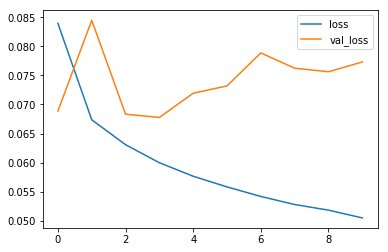

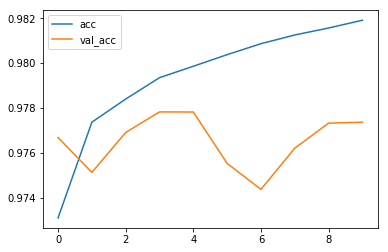

0.973533988080824


In [25]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

In [80]:
def single_predict(sentence):
    single_sequences = tokenizer.texts_to_sequences(sentence)
    pad_input=[[j for i in single_sequences for j in i]]
    single_data = pad_sequences(pad_input, maxlen=MAX_SEQUENCE_LENGTH)
    p = model.predict(single_data)
    print(p)

In [81]:
single_predict("anger on you")

[[0.9480501  0.3236057  0.80103266 0.10518105 0.60628474 0.18759683]]


In [82]:
single_predict("Love my county")

[[2.7017647e-01 2.2057282e-05 5.3103350e-02 9.8962490e-05 2.1354293e-02
  2.4954409e-03]]


In [ ]:
["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]